In [6]:
import json
import math
import random
from pathlib import Path
from pprint import pprint
from utils import load_dataset, create_dataset, write_test_data, gpt_prediction, eval_response, results_path

output_dir = results_path / "sentence_cap_short"
if not output_dir.exists():
    output_dir.mkdir(parents=True)
dataset, tag_counts = load_dataset("sentences.json")
print(len(dataset))
pprint(tag_counts)

ImportError: cannot import name 'write_test_data' from 'utils' (/Users/ishangaur/classification-faithfulness/utils.py)

In [ ]:
# fragments vs sentence; just subject/verb fragments vs all; test if class balance changes accuracy
tags_true = ["start_cap", "short"]
tags_false = ["start_lower", "long"]
adversarial_true = ["start_lower", "short"]
adversarial_false = ["start_cap", "long"]
tags_common = []
positives, negatives = create_dataset(dataset, tags_true, tags_false, tags_common, true_comb="AND", false_comb="AND")
adv_positives, adv_negatives = create_dataset(dataset, adversarial_true, adversarial_false, tags_common, true_comb="AND", false_comb="AND")

with open(output_dir / "dataset_tags.txt", "w") as f:
    f.write(f"tags_true: {tags_true}\n")
    f.write(f"tags_false: {tags_false}\n")
    f.write(f"adversarial_true: {adversarial_true}\n")
    f.write(f"adversarial_false: {adversarial_false}\n")
    f.write(f"tags_common: {tags_common}\n")

print(len(positives), len(negatives))
print(len(adv_positives), len(adv_negatives))

54 41
38 67


In [ ]:
pprint(positives)

[{'input': 'THE FLOWERS BLOOM IN SPRING.',
  'label': True,
  'tags': ['all_upper',
           'gpt4',
           'sentence',
           'short',
           'nature',
           'start_consonant',
           'start_cap',
           'odd_words',
           'start_the']},
 {'input': 'CHOCOLATE IS A DELIGHTFUL INDULGENCE.',
  'label': True,
  'tags': ['all_upper',
           'odd_words',
           'gpt4',
           'sentence',
           'short',
           'start_consonant',
           'start_cap']},
 {'input': 'Exploring new cities is always exciting.',
  'label': True,
  'tags': ['gpt4',
           'even_words',
           'sentence',
           'short',
           'start_vowel',
           'start_cap']},
 {'input': 'LAUGHTER IS THE BEST MEDICINE.',
  'label': True,
  'tags': ['all_upper',
           'odd_words',
           'gpt4',
           'sentence',
           'short',
           'start_consonant',
           'start_cap']},
 {'input': 'WHISPERING SECRETS TO THE NIGHT',
  'label'

In [ ]:
pprint(negatives)

[{'input': 'the ocean waves crash against the shore.',
  'label': False,
  'tags': ['gpt4',
           'sentence',
           'nature',
           'start_consonant',
           'long',
           'odd_words',
           'all_lower',
           'start_the',
           'start_lower',
           'shared_sample']},
 {'input': 'ancient artifacts telling stories of the past',
  'label': False,
  'tags': ['odd_words',
           'all_lower',
           'gpt4',
           'fragment_subject',
           'start_lower',
           'start_vowel',
           'long']},
 {'input': 'candles create a warm and inviting atmosphere.',
  'label': False,
  'tags': ['odd_words',
           'all_lower',
           'gpt4',
           'sentence',
           'start_lower',
           'start_consonant',
           'long']},
 {'input': 'the world is full of fascinating cultures.',
  'label': False,
  'tags': ['gpt4',
           'sentence',
           'start_consonant',
           'long',
           'odd_words',
  

In [7]:
sample_counts = [5, 10, 15]
response_jsons = []
for c in sample_counts:
    write_test_data(positives, negatives, c, output_dir)
    in_context_prompt = open(output_dir / f"in_context_prompt_{c}.txt").read()
    test_prompt = open(output_dir / f"test_prompt_{c}.txt").read()
    test_samples = json.load(open(output_dir / f"test_samples_{c}.json"))
    response_json = gpt_prediction(in_context_prompt, test_prompt, json_mode=True)
    json.dump(response_json, open(output_dir / f"response_{c}.json", "w"))
    response_jsons.append(response_json)

TypeError: write_test_data() takes 3 positional arguments but 4 were given

In [ ]:
sample_counts = [3, 5, 10, 15]
response_jsons = [json.load(open(output_dir / f"response_{c}.json")) for c in sample_counts]
test_samples = [json.load(open(output_dir / f"test_samples_{c}.json")) for c in sample_counts]

results = []
responses = []
for r, t in zip(response_jsons, test_samples):
    response, result = eval_response(r, t)
    results.append(result)
    responses.append(response)

In [ ]:
for c, r in zip(sample_counts, results):
    r["in_context_count"] = c
pprint(results)

[{'accuracy': 0.7162162162162162,
  'correct': 53,
  'corrupted': 0,
  'in_context_count': 3,
  'incorrect': 21,
  'mismatch': 0,
  'total': 74}]


In [ ]:
json.dump(responses, open(output_dir / "responses.json", "w"))
json.dump(results, open(output_dir / "results.json", "w"))

                   correct  mismatch  incorrect  corrupted
in_context_count                                          
3.0               0.716216       0.0   0.283784        0.0


Text(0.5, 1.0, 'Complete senteces vs Sentence fragments')

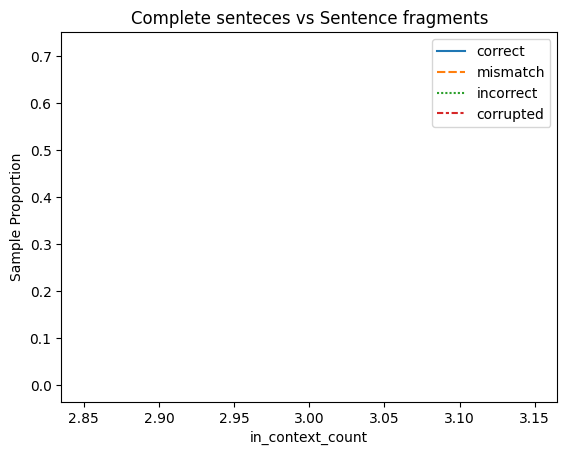

In [ ]:
import pandas as pd
import seaborn as sns

results = json.load(open(output_dir / "results.json"))

df = pd.DataFrame(results)
df.drop(columns=["accuracy"], inplace=True)

for col in df.columns:
    df[col] /= df["total"]
df.drop(columns=["total"], inplace=True)
df.set_index("in_context_count", inplace=True)
print(df)

ax = sns.lineplot(data=df)
ax.set_ylabel("Sample Proportion")
ax.set_title(f"Complete senteces vs Sentence fragments")